In [1]:
import numpy as np
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms
from datetime import datetime
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings("ignore")

In [2]:
from energy_rbm import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
# np.seterr(divide='ignore', invalid='ignore')


import re
from time import sleep

In [3]:
! nvidia-smi

/bin/sh: nvidia-smi: command not found


In [4]:
CUDA = torch.cuda.is_available()
CUDA_DEVICE = 0

if CUDA:
    device='cuda'
else:
    device='cpu'
torch.cuda.is_available()

False

In [5]:
CUDA

False

In [6]:
torch.backends.cudnn.enabled

True

# Train

In [7]:
n_hid_range=[4, 8, 16, 32, 64, 128]
# n_hid_range=[2, 128, 24, 48, 96]
# n_hid_range=[128]


n_vis=784
k=5
n_epochs=5001
batch_size=60
lr=0.01
vol=300

In [53]:
train_dataset = get_small_mnist(vol, 'train', [0,1])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)
#     test_dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, train=False, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = get_small_mnist(1000, 'test', [0,1])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2000)

In [54]:
def train_and_get_data(n_hid, vol, model, train_loader=train_loader, test_loader=test_loader):
    if model==0:
        rbm = RBM(n_vis, n_hid, k, use_cuda=False)
    else:
        rbm=model
        
#     train_op = optim.Adam(rbm.parameters(), lr)
    train_op = optim.SGD(rbm.parameters(), lr, momentum=0.9)

    # train the RBM model
    rbm.train()

    train_loss_list=[]
    test_loss_list=[]
    for epoch in tqdm(range(n_epochs)):
#     for epoch in trange(n_epochs):
#     for epoch in range(n_epochs):
        train_loss_epoch = []
        test_loss_epoch = []
        for _, (data, target) in enumerate(train_loader):
            data=data.to(device)
            v, v_gibbs = rbm(data.view(-1, 784))
            train_loss = rbm.free_energy(v) - rbm.free_energy(v_gibbs)
            train_loss_epoch.append(train_loss.item())
            train_op.zero_grad()
            train_loss.backward()
            train_op.step()
        for _, (data, target) in enumerate(test_loader):
            data=data.to(device)
            v, v_gibbs = rbm(data.view(-1, 784))
            test_loss = rbm.free_energy(v) - rbm.free_energy(v_gibbs)
            test_loss_epoch.append(test_loss.item())
        train_loss_list.append(np.mean(train_loss_epoch))
        test_loss_list.append(np.mean(test_loss_epoch))
#         if epoch in [100, 1000, 10000, 100000]:
#             print("epoch : {epoch}".format(epoch=epoch))

    with open('ERBM,SGD/lr=0.01/loss/2021-01-28_loss_n_hid={n_hid}_vol={v}_epoch={ep}.pkl'.format(n_hid=n_hid, v=vol*2, ep=epoch), 'wb') as f:
        pkl.dump([train_loss_list, test_loss_list], f)
    torch.save(rbm, 'ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol={v}_epoch={ep}'.format(n_hid=n_hid, v=vol*2, ep=epoch))
    

In [13]:
for n_hid in n_hid_range:
    train_and_get_data(n_hid, 300
#                    ,model=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=600_epoch=5000'.format(n_hid=n_hid)
                    ,0
                    ,train_loader=train_loader
                    ,test_loader=test_loader)
# for n_hid in n_hid_range:
#     train_and_get_data(n_hid, 300
#                    ,model=torch.load('ERBM,SGD/lr=0.05/models/2021-01-28_n_hid={n_hid}_vol=600_epoch=10000'.format(n_hid=n_hid))
#                    ,train_loader=train_loader
#                    ,test_loader=test_loader)


100%|██████████| 10001/10001 [56:20<00:00,  2.96it/s]


# make samples

In [10]:
def make_samples(model, n_sample=1000, step_eq=500):
    model=model.cpu()
    n_hid=len(model.h[0])
    step_eq=500
    v_samples=[]
    h_samples=[]
    encoded=[]
#     torch.cuda.empty_cache()
    train_dataset = get_small_mnist(6000, 'train', [0,1])
    train_loader = torch.utils.data.DataLoader(train_dataset, 1)
    for _, (data, target) in enumerate(train_loader):
#         data=data.cuda()
        encoded_sample = model.visible_to_hidden(data.view(-1, 784))
        encoded_sample = encoded_sample.bernoulli()
        encoded.append(str(encoded_sample.detach().cpu()))
    with open('ERBM,SGD/lr=0.01/encoded/2021-01-28_encoded2_n_hid={n_hid}_vol=600_epoch=5000.pkl'.format(n_hid=n_hid), 'wb') as f:
        pkl.dump(encoded, f)
        
    for n in tqdm(range(n_sample)):
#     for n in range(n_sample):
        input_random=torch.round(torch.rand(n_hid).view(1, n_hid))
        for i in range(step_eq):
            v_sample=model.hidden_to_visible(input_random)
            v_sample=v_sample.bernoulli()
            h_sample=model.visible_to_hidden(v_sample)
            h_sample=h_sample.bernoulli()
            input_random=h_sample
        v_sample=model.hidden_to_visible(h_sample)
#         v_samples.append(v_sample.view(1,28,28))
        v_samples.append(np.reshape(v_sample.tolist(),(28,28)))
        h_samples.append(str(h_sample.detach().cpu()))
    with open('ERBM,SGD/lr=0.01/samples/2021-01-28_samples2_n_hid={n_hid}_vol=600_epoch=5000.pkl'.format(n_hid=n_hid), 'wb') as f:
        pkl.dump(v_samples, f)
    with open('ERBM,SGD/lr=0.01/encoded/2021-01-28_encoded_n_hid={n_hid}_vol=600_epoch=5000.pkl'.format(n_hid=n_hid), 'wb') as f:
        pkl.dump(h_samples, f)


In [22]:
n_hid_range=[128]

model_list=[]
for i in n_hid_range:
    model_list.append(torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=600_epoch=5000'.format(n_hid=i), map_location=device))
for i in range(len(model_list)):
    make_samples(model_list[i], n_sample=1000, step_eq=500)

100%|██████████| 1000/1000 [00:33<00:00, 30.07it/s]


# load models

In [11]:
model_list=[]
for i in n_hid_range:
    model_list.append(torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=12000_epoch=5000'.format(n_hid=i), map_location=device))


# save parameters

In [12]:
# save parameters as pickle
a=model_list[4].h.detach().cpu()
a=np.squeeze(a.numpy())
with open('n_hid=64_vol_12000_h.pkl', 'wb') as f:
    pkl.dump(a, f)

# check E distribution

In [12]:
n_hid=4
step_eq=1
model0=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=12000_epoch=5000'.format(n_hid=n_hid), map_location=device).float()
model1=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=600_epoch=5000'.format(n_hid=n_hid), map_location=device).float()

# n_hid_energy=check_energy(model0, model1, n_sample=100000, step_eq=step_eq)
# n_hid_energy2=check_energy2(model0, model1, train_dataset)

In [13]:
def check_energy2(model0, model1, dataset):
    E0=[]; E1=[]
#     dataset=np.squeeze(dataset)
    for i in range(len(dataset)):
        #for MNIST set's shape
        E0.append(model0.energy(dataset[i][0].view(-1,784).bernoulli()).detach().numpy())
        E1.append(model1.energy(dataset[i][0].view(-1,784).bernoulli()).detach().numpy())
        #for generated set's shape
#         E0.append(model0.energy(dataset[i])[0].detach().numpy())
#         E1.append(model1.energy(dataset[i])[0].detach().numpy())

    return E0, E1

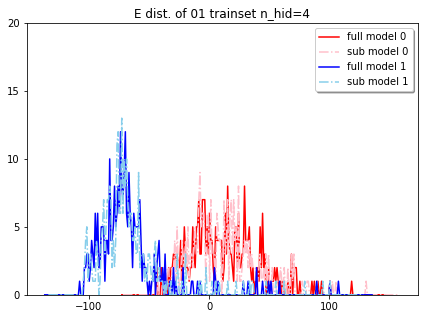

In [14]:
def get_hist(list00, color):
    bins=range(int(min(list00)-30), int(max(list00)+30), 1)
    y1,x1,_ = plt.hist(list00, bins = bins, histtype='step', color=color)
    x1 = 0.5*(x1[1:]+x1[:-1])
    return x1, y1

# n_hid=4
model0=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=12000_epoch=5000'.format(n_hid=n_hid), map_location=device).float()
model1=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=600_epoch=5000'.format(n_hid=n_hid), map_location=device).float()
train_dataset = get_small_mnist(6000, 'train', [0, 1])
n_hid_energy2=check_energy2(model0, model1, train_dataset)

x0,y0=get_hist(np.squeeze(check_energy2(model0, model1, get_small_mnist(vol, 'train', [0]))[0]), 'red')
x1,y1=get_hist(np.squeeze(check_energy2(model0, model1, get_small_mnist(vol, 'train', [0]))[0]), 'pink')
x2,y2=get_hist(np.squeeze(check_energy2(model0, model1, get_small_mnist(vol, 'train', [1]))[0]), 'blue')
x3,y3=get_hist(np.squeeze(check_energy2(model0, model1, get_small_mnist(vol, 'train', [1]))[0]), 'skyblue')
plt.close()

plt.figure(figsize=(7,5))

plt.plot(x0, y0, '-', color='red',)
plt.plot(x1, y1, '-.', color='pink',)
plt.plot(x2, y2, '', color='blue',)
plt.plot(x3, y3, '-.', color='skyblue',)
plt.title('E dist. of 01 trainset n_hid={n_hid}'.format(n_hid=n_hid))
plt.legend(['full model 0', 'sub model 0', 'full model 1', 'sub model 1'],
           loc='upper right',
           ncol=1, fancybox=True, shadow=True)
# plt.text(350, 0.1, '~$k^{2.1}$ ', fontsize=20)
plt.rcParams["font.size"] = "20"
plt.ylim([0,20])
# plt.axis([-150, 200, 0, 20])
# plt.savefig('image/IEvsn_hid.png', pad_inches=10)
plt.plot()
plt.show()


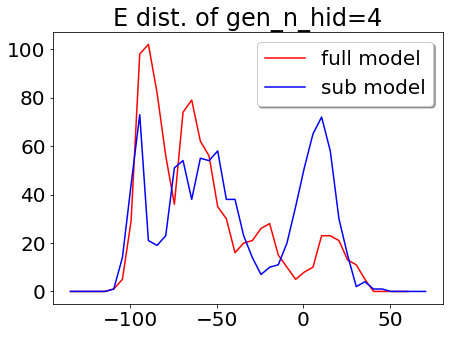

In [15]:
def get_hist(list00, color):
    bins=range(int(min(list00)-30), int(max(list00)+30), 5)
    y1,x1,_ = plt.hist(list00, bins = bins, histtype='step', color=color)
    x1 = 0.5*(x1[1:]+x1[:-1])
    return x1, y1

# n_hid=4
dataset0=pd.read_pickle('ERBM,SGD/lr=0.01/samples/2021-01-28_samples2_n_hid={n_hid}_vol=12000_epoch=5000.pkl'.format(n_hid=n_hid))
dataset0=torch.tensor(np.array(dataset0).reshape(1000, 1, 784)).float()
dataset1=pd.read_pickle('ERBM,SGD/lr=0.01/samples/2021-01-28_samples2_n_hid={n_hid}_vol=600_epoch=5000.pkl'.format(n_hid=n_hid))
dataset1=torch.tensor(np.array(dataset1).reshape(1000, 1, 784)).float()

n_hid_energy0=check_energy2(model0, model1, dataset0)
n_hid_energy1=check_energy2(model0, model1, dataset1)

x0,y0=get_hist(np.squeeze(check_energy2(model0, model1, dataset0)[0]), 'red')
x1,y1=get_hist(np.squeeze(check_energy2(model0, model1, dataset1)[0]), 'pink')

plt.close()

plt.figure(figsize=(7,5))
plt.plot(x0, y0, '-', color='red')
plt.plot(x1, y1, '-', color='blue')


plt.title('E dist. of gen_n_hid={n_hid}'.format(n_hid=n_hid))
plt.legend(['full model', 'sub model'],
           loc='upper right',
           ncol=1, fancybox=True, shadow=True)

# plt.text(350, 0.1, '~$k^{2.1}$ ', fontsize=20)
plt.rcParams["font.size"] = "20"
# plt.ylim([0, 200])
# plt.axis([-150, 200, 0, 500])
# plt.savefig('image/IEvsn_hid.png', pad_inches=10)
plt.plot()
plt.show()


# combin samples

In [16]:
n_hid=4
model0=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=12000_epoch=5000'.format(n_hid=n_hid), map_location=device).float()
model1=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=600_epoch=5000'.format(n_hid=n_hid), map_location=device).float()
train_dataset = get_small_mnist(6000, 'train', [0, 1])
n_hid_energy2=check_energy2(model0, model1, train_dataset)
def combine_trainset_genset(train_dataset, dataset0, dataset1):
    a=(train_dataset.data/255).view(len(train_dataset),784)
    b=dataset0.view(len(dataset0), 784)
    c=dataset0.view(len(dataset1), 784)    
    return torch.cat((a,b,c))
com_config=combine_trainset_genset(train_dataset, dataset0, dataset1)

# Gibbs E distribution

In [7]:

n_hid=8
model0=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=12000_epoch=5000'.format(n_hid=n_hid), map_location=device).float()

def binary_to_decimal(list0):
    value=0
    for i in range(len(list0)):
        value+=list0[-i-1]*2**(i)
    return value

def decimal_to_binary(integer):
    string=bin(integer)[2:]
    list0=[float(d) for d in string]
    while len(list0)<n_hid:
        list0=[0.]+list0
    return torch.tensor([list0])

def check_energy(model0, n_sample=10000, step_eq=500):
    n_vis=len(model0.v[0]); n_hid=len(model0.h[0])
    state_E_dict={}
    hidden_state_list=[]
    for i in range(2**n_hid):
        state_E_dict[str(i)]=0
    # for i in range(2**n_hid):
    for i in [0]:
        hidden_state_list.append(decimal_to_binary(i))
    # for i in tqdm(range(len(hidden_state_list))):
    for i in range(len(hidden_state_list)):
        h_sample=hidden_state_list[i].to(device).detach()
        for j in range(step_eq):
            v_sample=model0.hidden_to_visible(h_sample).detach()
            v_sample=v_sample.bernoulli().detach()
            h_sample=model0.visible_to_hidden(v_sample).detach()
            h_sample=h_sample.bernoulli().detach()
        v_sample=model0.hidden_to_visible(h_sample).detach()
        v_sample=v_sample.bernoulli().detach()
        for n in tqdm(range(n_sample)):
        # for n in range(n_sample):
            h_sample=model0.visible_to_hidden(v_sample).detach()
            h_sample=h_sample.bernoulli().detach()
            v_sample=model0.hidden_to_visible(h_sample).detach()
            v_sample=v_sample.bernoulli().detach()
            # state_E_dict[str(binary_to_decimal(h_sample.view(4).int().detach().numpy()))].append(model0.energy2(v_sample, h_sample).detach().numpy()[0][0].astype(int))
            state_E_dict[str(binary_to_decimal(h_sample.view(n_hid).cpu().int().detach().numpy()))]+=1
#     print(state_E_dict)
    with open('state_E_dict_n_hid={n_hid}_n_sample={n_sample}.pkl'.format(n_hid=n_hid, n_sample=n_sample), 'wb') as f:
        pkl.dump(state_E_dict, f)


In [ ]:

check_energy(model0, n_sample=100000000, step_eq=1)

 11%|█         | 10954243/100000000 [16:00<2:10:30, 11370.95it/s]

In [13]:
a=pd.read_pickle('state_E_dict_n_hid=8.pkl')

In [14]:
a

{'0': 0,
 '1': 0,
 '2': 685415,
 '3': 0,
 '4': 0,
 '5': 0,
 '6': 0,
 '7': 0,
 '8': 0,
 '9': 0,
 '10': 0,
 '11': 0,
 '12': 0,
 '13': 0,
 '14': 0,
 '15': 0,
 '16': 0,
 '17': 615,
 '18': 560686,
 '19': 200503,
 '20': 4286073,
 '21': 2013,
 '22': 71241,
 '23': 0,
 '24': 0,
 '25': 0,
 '26': 0,
 '27': 0,
 '28': 0,
 '29': 0,
 '30': 0,
 '31': 0,
 '32': 0,
 '33': 0,
 '34': 816,
 '35': 0,
 '36': 0,
 '37': 0,
 '38': 0,
 '39': 0,
 '40': 0,
 '41': 0,
 '42': 0,
 '43': 0,
 '44': 0,
 '45': 0,
 '46': 0,
 '47': 0,
 '48': 0,
 '49': 0,
 '50': 13137,
 '51': 0,
 '52': 228753,
 '53': 0,
 '54': 238573,
 '55': 0,
 '56': 0,
 '57': 0,
 '58': 0,
 '59': 0,
 '60': 0,
 '61': 0,
 '62': 0,
 '63': 0,
 '64': 0,
 '65': 0,
 '66': 8158845,
 '67': 337,
 '68': 0,
 '69': 0,
 '70': 0,
 '71': 0,
 '72': 0,
 '73': 0,
 '74': 0,
 '75': 0,
 '76': 0,
 '77': 0,
 '78': 0,
 '79': 0,
 '80': 0,
 '81': 24338,
 '82': 82630,
 '83': 4394041,
 '84': 865718,
 '85': 1499965,
 '86': 11397,
 '87': 695,
 '88': 0,
 '89': 0,
 '90': 0,
 '91': 0,
 '92'

In [8]:
for i in range(len(list(a.keys()))):
    print(len(list(a.values())[i]))

TypeError: object of type 'int' has no len()

In [95]:
for i in range(len(list(a.keys()))):
    print(len(list(a.values())[i]))

2000000
1203400
2000000
0
164659
31896
10600045
0
0
0
0
0
0
0
0
0


In [ ]:
n_hid_energy=check_energy(model0, model1, n_sample=10000000, step_eq=1)
plt.figure(figsize=(7,5))
plt.plot(range(len(n_hid_energy[0])), list(n_hid_energy[0]), '-o', color='red', alpha=0.1)
plt.plot(range(len(n_hid_energy[1])), list(n_hid_energy[1]), '-o', color='green', alpha=0.1)
# plt.plot(range(len(n_hid_energy[2])), list(n_hid_energy[2]), '-o', color='blue', alpha=0.3)
plt.grid(True)
plt.xlabel('Gibbs steps', fontsize=20)
plt.ylabel('RBM energy', fontsize=20)
# plt.title('n_hid={n_hid}, eq={step_eq}'.format(n_hid=n_hid, step_eq=step_eq))
plt.title('n_hid={n_hid}'.format(n_hid=n_hid))
plt.legend(['E0', 'E1', 'E1-E0'],
           loc='lower right', bbox_to_anchor=(1.3, 0.01), 
           ncol=1, fancybox=True, shadow=True)

# plt.text(350, 0.1, '~$k^{2.1}$ ', fontsize=20)
plt.rcParams["font.size"] = "20"
# plt.axis([2**5, 2**9, 0, 16])
# plt.savefig('image/IEvsn_hid.png', pad_inches=10)
plt.plot()
plt.show()



In [23]:
print(min(n_hid_energy[0]), max(n_hid_energy[0]))

-22.215847 69.7738


In [25]:
print(min(n_hid_energy[0]), max(n_hid_energy[0]))

-20.057194 74.38777


In [27]:
print(min(n_hid_energy[0]), max(n_hid_energy[0]))

-21.166048 66.963684


In [152]:
dict_config_E={}
for i in range(len(E0)):
    dict_config_E[com_config[i].round().int()]=int(np.round(E0[i]))

In [154]:
with open('combined_config_E.pkl', 'wb') as f:
    pkl.dump(dict_config_E, f)

$
\left\langle F_V \right\rangle _{q_{V}} + \left\langle E'_{VH}-E_{VH} \right\rangle _{P_{VH}}-F'
$


In [19]:
n_hid_range=[4, 8, 16, 32, 64]
for n_hid in n_hid_range:
    print('n_hid={n_hid}'.format(n_hid=n_hid))
    model0=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=12000_epoch=5000'.format(n_hid=n_hid)).float()
    v_sample0=torch.tensor(np.reshape(pd.read_pickle('ERBM,SGD/lr=0.01/samples/2021-01-28_samples2_n_hid={n_hid}_vol=12000_epoch=5000.pkl'.format(n_hid=n_hid)), (1000, 1, 784))).cuda().float()

    check_energy(model0, v_sample0)

n_hid=4
max:89.69696044921875, min:-16.539966583251953
n_hid=8
max:178.9167022705078, min:87.54429626464844
n_hid=16
max:34.393798828125, min:-80.123291015625
n_hid=32
max:115.65156555175781, min:-13.658447265625
n_hid=64
max:187.50131225585938, min:67.38631439208984


In [44]:
data0=get_small_mnist(6000, 'train')
data0=(get_small_mnist(6000, 'train').data.view(len(data0.data),784)/255.).cuda()
for n_hid in n_hid_range:
    model0=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=12000_epoch=5000'.format(n_hid=n_hid)).float()
    model1=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=600_epoch=5000'.format(n_hid=n_hid)).float()

    v_sample0=torch.tensor(np.reshape(pd.read_pickle('ERBM,SGD/lr=0.01/samples/2021-01-28_samples2_n_hid={n_hid}_vol=12000_epoch=5000.pkl'.format(n_hid=n_hid)), (1000, 1, 784))).cuda().float()
    
    print('n_hid={n_hid}, IG_loss={IG_loss}'.format(n_hid=n_hid, IG_loss=IG_loss(model0, model1, data0, v_sample0)))

n_hid=4, IG_loss=(-27.35398292541504, 39.349266052246094, 58.01517868041992)
n_hid=8, IG_loss=(-136.95103454589844, 62.85564422607422, 153.4291534423828)
n_hid=16, IG_loss=(25.486005783081055, 41.09246063232422, 1.4457576274871826)
n_hid=32, IG_loss=(-26.709373474121094, 45.54371643066406, 84.99322509765625)
n_hid=64, IG_loss=(-115.40055847167969, 83.30638885498047, 132.1706085205078)
